In [2]:
!pip install "numpy>=1.26,<2"


import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
!pip install emoji
import emoji
%matplotlib inline

#importing rdkit
!pip install rdkit
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors
from rdkit import RDConfig
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit.Chem import PandasTools
from rdkit import DataStructs
from rdkit.Chem.Subshape import SubshapeBuilder, SubshapeAligner, SubshapeObjects

#importing sklearn
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR

# Import mordred and padelpy
!pip install mordred
!pip install padelpy
import padelpy

#from mordred import Calculator, descriptors
from mordred import Calculator, descriptors



In [4]:
from rdkit.Chem import AllChem
from rdkit import Chem
import pandas as pd

sol = pd.read_csv('new222new.csv')
print(sol.head)
XY = sol.set_index('SMILES').T.to_dict('list')

<bound method NDFrame.head of                                                  SMILES  \
0               OCC1OC(CO)(OC2OC(CO)C(O)C(O)C2O)C(O)C1O   
1     O[C@H]1[C@H](O[C@H](CO)[C@@H](O)[C@@H]1O)O[C@]...   
2     OC[C@@H]1O[C@](CO)(O[C@@H]2O[C@@H](CO)[C@H](O)...   
3                CN1C[C@@H]2C[C@@H](C1)C3=CC=CC(=O)N3C2   
4                          CN1CC2CC(C1)C1=CC=CC(=O)N1C2   
...                                                 ...   
8433                                      O=[N+]([O-])C   
8434                                                 OC   
8435                                            S=C(N)N   
8436                                           O=C(NO)N   
8437                                            O=C(N)N   

      measured log(solubility:mol/L)  
0                               0.79  
1                               0.79  
2                               0.79  
3                               0.65  
4                               0.65  
...                        

In [5]:
Y = sol.iloc[:,1]
Y

,measured log(solubility:mol/L)
0,0.79
1,0.79
2,0.79
3,0.65
4,0.65
...,...
8433,0.26
8434,1.57
8435,0.32
8436,1.12


In [6]:
#descriptor
molecules = sol.SMILES.apply(Chem.MolFromSmiles)
def All_Mordred_descriptors(data):
    calc = Calculator(descriptors, ignore_3D=True)
    mols = [Chem.MolFromSmiles(smi) for smi in data]

    # pandas df
    df = calc.pandas(mols)
    return df

In [7]:
mordred_descriptors = All_Mordred_descriptors(sol['SMILES'])

100%|██████████| 8438/8438 [12:40<00:00, 11.10it/s]


In [11]:
X=mordred_descriptors

In [ ]:
#X.to_excel(r'D:/python/rdkit/experiments.xlsx', index = False)

In [9]:
from sklearn.feature_selection import VarianceThreshold   #import a tool that removes descriptors with very low variation

vt = VarianceThreshold()                                  #This creates the tool (vt) with default settings
                                                          #By default, it will remove any column where all the values are the same (variance = 0).

In [12]:
des_num = X.select_dtypes(include='number')               #
des_num.shape

(8438, 809)

In [13]:
transformed = vt.fit_transform(des_num)                   #removes columns from your des_num DataFrame that have very low or zero variance

In [14]:
_ = vt.fit(des_num)

mask = vt.get_support()                                  #mask[i] == True means the i-th descriptor has high enough variance and is kept.

In [15]:
des_num = des_num.loc[:, mask]                           #Keep only the columns (features/descriptors) where mask is True.

In [16]:
#selects and keeps only the molecular descriptors (features) that vary enough (variance > 0.1),
vt = VarianceThreshold(threshold=0.1)

# Fit
_ = vt.fit(des_num)

# Get the boolean mask
mask = vt.get_support()

des_reduced = des_num.loc[:, mask]
H=des_reduced
#X=H.drop(['FilterItLogS', 'SLogP'], axis=1)
X=H
X.shape

(8438, 504)

In [17]:
correlated_features = set()
correlation_matrix=X.corr()

In [18]:
for i in range(len(correlation_matrix .columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)

In [25]:
len(correlated_features)


328

In [26]:
print(correlated_features)

{'ATS8v', 'AATS1Z', 'ZMIC3', 'MWC06', 'Xp-1d', 'piPC1', 'AATS0Z', 'SRW02', 'nBonds', 'ATS2se', 'ATS6Z', 'ATSC0se', 'LabuteASA', 'EState_VSA9', 'ZMIC5', 'piPC9', 'ATS3d', 'SMR_VSA5', 'MPC3', 'MIC5', 'Xp-4d', 'NsCl', 'ATS5pe', 'Xpc-4d', 'AATS0are', 'Xpc-4dv', 'piPC8', 'ATS3p', 'SssNH', 'NaaCH', 'ATS0are', 'Xp-5dv', 'Xch-7dv', 'ATSC7m', 'MIC3', 'ATS7m', 'ATS6pe', 'TpiPC10', 'fragCpx', 'ATS3m', 'apol', 'SRW08', 'MIC4', 'CIC4', 'ATSC7pe', 'TIC5', 'MPC7', 'ATS1dv', 'AATS0p', 'ATS2i', 'MPC4', 'SaaCH', 'piPC6', 'Sse', 'ATS4d', 'MIC1', 'nFHRing', 'TIC0', 'ZMIC0', 'Xp-5d', 'SssCH2', 'ATS0m', 'ATS2dv', 'MPC5', 'ATS6i', 'ATSC8pe', 'AATS1se', 'SMR_VSA3', 'IC2', 'MIC0', 'TIC1', 'ATS8are', 'ATS1v', 'ATS5dv', 'bpol', 'SMR_VSA1', 'CIC5', 'TMWC10', 'ATS7pe', 'SMR_VSA7', 'ATS2m', 'TIC3', 'TSRW10', 'ATS7are', 'ATS3pe', 'ATSC5pe', 'ATSC1are', 'ATS1se', 'ATS4se', 'Xpc-6dv', 'ATS5d', 'AATS1d', 'ATSC6p', 'AATSC1dv', 'GGI4', 'MWC01', 'SaaNH', 'ATSC8p', 'n6Ring', 'ATS6p', 'SaaaC', 'ATSC2m', 'Diameter', 'ATS7Z',

In [27]:
#X.drop(labels=correlated_features, axis=1, inplace=True)

KeyError: "['ATS8v', 'AATS1Z', 'ZMIC3', 'MWC06', 'Xp-1d', 'piPC1', 'AATS0Z', 'SRW02', 'nBonds', 'ATS2se', 'ATS6Z', 'ATSC0se', 'LabuteASA', 'EState_VSA9', 'ZMIC5', 'piPC9', 'ATS3d', 'SMR_VSA5', 'MPC3', 'MIC5', 'Xp-4d', 'NsCl', 'ATS5pe', 'Xpc-4d', 'AATS0are', 'Xpc-4dv', 'piPC8', 'ATS3p', 'SssNH', 'NaaCH', 'ATS0are', 'Xp-5dv', 'Xch-7dv', 'ATSC7m', 'MIC3', 'ATS7m', 'ATS6pe', 'TpiPC10', 'fragCpx', 'ATS3m', 'apol', 'SRW08', 'MIC4', 'CIC4', 'ATSC7pe', 'TIC5', 'MPC7', 'ATS1dv', 'AATS0p', 'ATS2i', 'MPC4', 'SaaCH', 'piPC6', 'Sse', 'ATS4d', 'MIC1', 'nFHRing', 'TIC0', 'ZMIC0', 'Xp-5d', 'SssCH2', 'ATS0m', 'ATS2dv', 'MPC5', 'ATS6i', 'ATSC8pe', 'AATS1se', 'SMR_VSA3', 'IC2', 'MIC0', 'TIC1', 'ATS8are', 'ATS1v', 'ATS5dv', 'bpol', 'SMR_VSA1', 'CIC5', 'TMWC10', 'ATS7pe', 'SMR_VSA7', 'ATS2m', 'TIC3', 'TSRW10', 'ATS7are', 'ATS3pe', 'ATSC5pe', 'ATSC1are', 'ATS1se', 'ATS4se', 'Xpc-6dv', 'ATS5d', 'AATS1d', 'ATSC6p', 'AATSC1dv', 'GGI4', 'MWC01', 'SaaNH', 'ATSC8p', 'n6Ring', 'ATS6p', 'SaaaC', 'ATSC2m', 'Diameter', 'ATS7Z', 'ATS8d', 'ATS5v', 'WPol', 'MWC10', 'SRW05', 'nBondsM', 'ATSC7se', 'ATS3se', 'ATSC4pe', 'ATS5Z', 'ATS3are', 'MIC2', 'GGI3', 'NdO', 'ATS5m', 'SaasN', 'Xp-3dv', 'mZagreb2', 'TopoPSA', 'Sm', 'SsF', 'MWC07', 'piPC10', 'MPC10', 'ATS7v', 'Xpc-6d', 'Xp-6d', 'CIC2', 'MW', 'MWC02', 'ATS7se', 'SMR_VSA2', 'n6aHRing', 'NsBr', 'ATSC6m', 'ATSC0m', 'ATS6d', 'CIC3', 'ATSC0Z', 'ATS0se', 'MPC6', 'ATS1are', 'ZMIC1', 'VSA_EState5', 'ATS5se', 'SssssC', 'Xpc-5d', 'GGI2', 'ATS3Z', 'ATSC0are', 'ATS0v', 'SsssN', 'naRing', 'ATS8p', 'Xp-7d', 'SdsCH', 'SLogP', 'ATS1pe', 'ATS7dv', 'IC5', 'Sv', 'ATS8pe', 'ATSC3pe', 'Xp-2dv', 'ATS6dv', 'ATS2Z', 'SlogP_VSA8', 'C2SP2', 'AMW', 'ATS6are', 'nAromBond', 'AATSC1v', 'SsBr', 'FCSP3', 'ATS3i', 'Xp-1dv', 'ATSC0d', 'SddssS', 'WPath', 'ATS3dv', 'Xp-4dv', 'piPC2', 'SlogP_VSA6', 'ATSC5m', 'ATS6se', 'Si', 'SZ', 'SsNH2', 'ATS5i', 'ATSC2are', 'ATSC0pe', 'ATS8m', 'ATS8dv', 'ATSC4m', 'Sp', 'Zagreb1', 'SRW09', 'piPC3', 'SlogP_VSA5', 'TIC2', 'n6aRing', 'AATSC0Z', 'nBondsA', 'SRW06', 'Xp-2d', 'nBondsKD', 'nRing', 'ATS2pe', 'ATS6m', 'ATSC2pe', 'SddsN', 'MWC03', 'ATS8se', 'Sare', 'piPC4', 'ATS2v', 'ATS5are', 'ATSC6pe', 'ATS8i', 'AATS1v', 'ATSC3m', 'ATSC5are', 'ATSC2p', 'ATS0d', 'ZMIC2', 'CIC0', 'SsCl', 'Xc-3d', 'AATS0pe', 'MWC09', 'Xp-3d', 'SRW07', 'ATSC1pe', 'ATS1i', 'MWC08', 'SRW10', 'AATS1dv', 'ATS7i', 'GGI1', 'ATS6v', 'ATS1p', 'IC4', 'ATSC6are', 'ATS4p', 'Xp-7dv', 'nBondsKS', 'ATS4v', 'ATS1Z', 'ATS4m', 'ATS2are', 'AATS1are', 'ATS4dv', 'VSA_EState6', 'ATS3v', 'ATS2d', 'MWC05', 'TIC4', 'ATS4i', 'ZMIC4', 'ATS2p', 'ATS7p', 'ATSC8m', 'ATS1m', 'AATS0m', 'ATSC3are', 'AATS0v', 'VSA_EState3', 'BertzCT', 'ATSC8se', 'ATSC0dv', 'SRW04', 'TopoPSA(NO)', 'ATS0i', 'ATS0pe', 'VMcGowan', 'IC3', 'AATSC0m', 'ATSC4are', 'ATSC7are', 'ATSC0p', 'AATS1i', 'ATS5p', 'Mm', 'ATSC0v', 'SaaN', 'nH', 'MWC04', 'ATS4are', 'nBondsO', 'AATS1pe', 'ATS0dv', 'ATS4pe', 'Xp-6dv', 'piPC7', 'ATS4Z', 'AATS1m', 'SssO', 'MPC8', 'Zagreb2', 'n5aHRing', 'SMR', 'piPC5', 'Spe', 'Xpc-5dv', 'MPC2', 'SsOH', 'nBondsS', 'AATSC1m', 'ATS0p', 'AATS1p', 'ATSC8are', 'SdO', 'AATSC1i', 'AATS0se', 'SsCH3', 'ATS7d', 'ATS1d', 'ATSC1m', 'TMPC10', 'NsF', 'ATS8Z', 'MPC9', 'Radius', 'EState_VSA10'] not found in axis"

In [28]:
X.drop(labels=correlated_features, axis=1, inplace=True, errors='ignore')


<ipython-input-28-9039180b3fca>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.drop(labels=correlated_features, axis=1, inplace=True, errors='ignore')


In [29]:
X.drop('FilterItLogS', axis=1, inplace=True)

<ipython-input-29-9c6bf4754336>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.drop('FilterItLogS', axis=1, inplace=True)


In [30]:
X.shape

(8438, 175)

In [31]:
X.head()

,nAcid,nBase,nAromAtom,nAtom,nHeavyAtom,nBridgehead,nHetero,nC,nN,nO,...,n5HRing,n6HRing,n5aRing,naHRing,nARing,n5ARing,n6ARing,nAHRing,nFRing,nRot
0,0,0,0,45,23,0,11,12,0,11,...,1,1,0,0,2,1,1,2,0,5
1,0,0,0,45,23,0,11,12,0,11,...,1,1,0,0,2,1,1,2,0,5
2,0,0,0,45,23,0,11,12,0,11,...,1,1,0,0,2,1,1,2,0,5
3,0,1,6,31,15,2,3,12,2,1,...,0,3,0,1,2,0,2,2,1,0
4,0,1,6,31,15,2,3,12,2,1,...,0,3,0,1,2,0,2,2,1,0


In [32]:
gf=set()                          #creating an empty set named gf.


In [33]:
#adding all column names from the DataFrame X into the set gf.
i=0
for i in range(len(X.columns)):

    colname = X.columns[i]
    gf.add(colname)

In [34]:
gf

{'AATS0d',
 'AATS0dv',
 'AATS0i',
 'AATSC0dv',
 'AATSC0i',
 'AATSC0v',
 'AATSC1Z',
 'ATS0Z',
 'ATSC0i',
 'ATSC1Z',
 'ATSC1d',
 'ATSC1dv',
 'ATSC1i',
 'ATSC1p',
 'ATSC1se',
 'ATSC1v',
 'ATSC2Z',
 'ATSC2d',
 'ATSC2dv',
 'ATSC2i',
 'ATSC2se',
 'ATSC2v',
 'ATSC3Z',
 'ATSC3d',
 'ATSC3dv',
 'ATSC3i',
 'ATSC3p',
 'ATSC3se',
 'ATSC3v',
 'ATSC4Z',
 'ATSC4d',
 'ATSC4dv',
 'ATSC4i',
 'ATSC4p',
 'ATSC4se',
 'ATSC4v',
 'ATSC5Z',
 'ATSC5d',
 'ATSC5dv',
 'ATSC5i',
 'ATSC5p',
 'ATSC5se',
 'ATSC5v',
 'ATSC6Z',
 'ATSC6d',
 'ATSC6dv',
 'ATSC6i',
 'ATSC6se',
 'ATSC6v',
 'ATSC7Z',
 'ATSC7d',
 'ATSC7dv',
 'ATSC7i',
 'ATSC7p',
 'ATSC7v',
 'ATSC8Z',
 'ATSC8d',
 'ATSC8dv',
 'ATSC8i',
 'ATSC8v',
 'BalabanJ',
 'C1SP2',
 'C1SP3',
 'C2SP3',
 'C3SP2',
 'C3SP3',
 'CIC1',
 'ECIndex',
 'EState_VSA1',
 'EState_VSA2',
 'EState_VSA3',
 'EState_VSA4',
 'EState_VSA5',
 'EState_VSA6',
 'EState_VSA7',
 'EState_VSA8',
 'GATS1i',
 'GATS1p',
 'IC1',
 'NaaN',
 'NaaNH',
 'NaaaC',
 'NaasC',
 'NaasN',
 'NddsN',
 'NddssS',
 'NdsCH',

In [35]:
len(gf)


175

In [36]:
#X.to_excel(r'D:/python/rdkit/file name descriptor 8000data.xlsx', index = False)

OSError: Cannot save file into a non-existent directory: 'D:/python/rdkit'

In [38]:
#extracts the second column from the DataFrame sol and stores it in the variable y.
y = sol.iloc[:,1]
y

,measured log(solubility:mol/L)
0,0.79
1,0.79
2,0.79
3,0.65
4,0.65
...,...
8433,0.26
8434,1.57
8435,0.32
8436,1.12


In [40]:
#data split
#Splitting the dataset into training (80%) and testing (20%) using train_test_split
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2,random_state=991)
#test size is 20% and traing size is 80%

#linear regression
#Importing linear regression tools from scikit-learn to build and evaluate a linear regression model
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [42]:
#model learning the relationship between descriptors (X) and the target variable (y),solubility.

reg = LinearRegression()      #Creates a linear regression model named reg
reg.fit(X, y)                 #Fits/trains the model on entire dataset (X, y) using reg.fit(X, y).

LinearRegression()

In [44]:
#predicts the X_train
#evaluates the performance using Root Mean Squared Error (RMSE) and R² (coefficient of determination) on training dataset.

Y_pred_train = reg.predict(X_train)
#print('Coefficients:', model.coef_)
#print('Intercept:', model.intercept_)
print('Mean squared error (MSE): %.2f'
      % mean_squared_error(Y_train, Y_pred_train))        #lower is better
print('Coefficient of determination (R^2): %.2f'
      % r2_score(Y_train, Y_pred_train))                  #1 is perfect prediction


Mean squared error (MSE): 0.68
Coefficient of determination (R^2): 0.80


In [47]:
#predicts the X_test
#evaluates the performance using Root Mean Squared Error (RMSE) and R² (coefficient of determination) on testing dataset.

Y_pred_test = reg.predict(X_test)
#print('Coefficients:', model.coef_)44444444444
#print('Intercept:', model.intercept_)
print('Mean squared error (MSE): %.2f'
      % mean_squared_error(Y_test, Y_pred_test))
print('Coefficient of determination (R^2): %.2f'
      % r2_score(Y_test, Y_pred_test))

Mean squared error (MSE): 0.64
Coefficient of determination (R^2): 0.82


In [50]:
from sklearn.metrics import mean_absolute_error


In [52]:
#calculates the Mean Absolute Error (MAE) between the actual and predicted values of test data
mae = mean_absolute_error(Y_test, Y_pred_test)
mae

0.6094298985809948

In [54]:
#calculates the Mean Absolute Error (MAE) on the training data
mae = mean_absolute_error(Y_train, Y_pred_train)
mae

0.6191889026552789

In [56]:
#manually calculates the Root Mean Squared Error (RMSE) for the training data
residuals= Y_train - Y_pred_train
mse=np.mean(residuals**2)
RMSE = np.sqrt(mse)
RMSE

0.824002922303022

In [57]:
#creates and trains a Random Forest Regressor model using 100 decision trees on the training data X_train and Y_train
model = RandomForestRegressor(n_estimators=100, random_state=42)               #random_state=42 is like setting a "fixed lucky number" so that every time you run your model, it gives the same results.
model.fit(X_train, Y_train)

RandomForestRegressor(random_state=42)

In [60]:
#predicts the X_train
#evaluating the performance of model on training data using MSE , R²

Y_pred_train = model.predict(X_train)
#print('Coefficients:', model.coef_)
#print('Intercept:', model.intercept_)
print('Mean squared error (RMSE): %.2f'
      % mean_squared_error(Y_train, Y_pred_train))
print('Coefficient of determination (R^2): %.2f'
      % r2_score(Y_train, Y_pred_train))

Mean squared error (RMSE): 0.06
Coefficient of determination (R^2): 0.98


In [63]:
#evaluating the performance of model on test data using MSE ,R²

Y_pred_test = model.predict(X_test)
print('Mean squared error (MSE): %.2f'
      % mean_squared_error(Y_test, Y_pred_test))
print('Coefficient of determination (R^2): %.2f'
      % r2_score(Y_test, Y_pred_test))

Mean squared error (MSE): 0.41
Coefficient of determination (R^2): 0.88


In [64]:
mae = mean_absolute_error(Y_test, Y_pred_test)
mae

0.4180376687592601

In [65]:
mae = mean_absolute_error(Y_train, Y_pred_train)
mae

0.16650680554026034

In [66]:
residuals= Y_train - Y_pred_train
mse=np.mean(residuals**2)
RMSE = np.sqrt(mse)
RMSE

0.25478845380389586

In [67]:
import shap                                                #for model interpretability (to explain model predictions).
from sklearn.preprocessing import StandardScaler           #to scale/normalize the features (make them have mean 0, std 1)
import os
import sys

In [68]:
explainer = shap.Explainer(model)                         #this tool help understand how the model makes predictions.
shap_values = explainer(X_test)                           #Calculates SHAP values for the test data
                                                          #hese values show how each feature in X_test affects the model’s prediction for each sample.

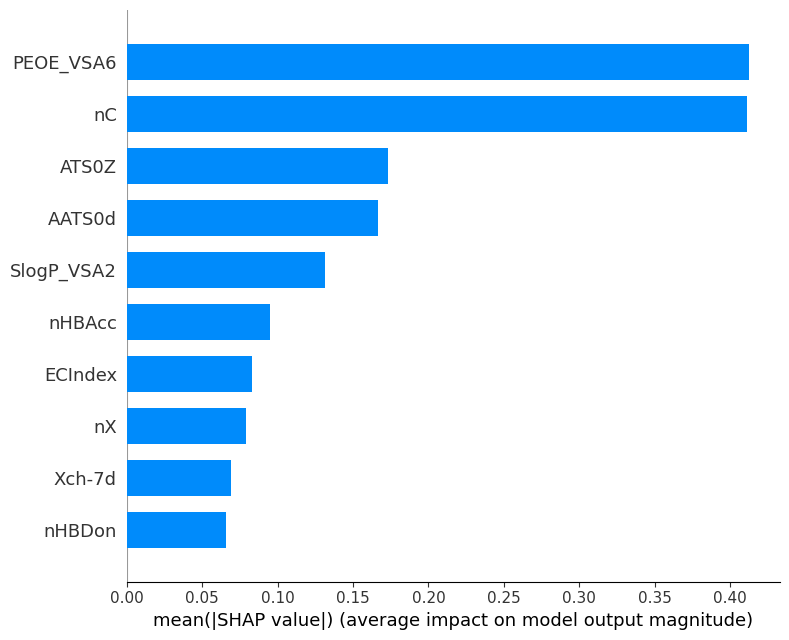

In [69]:
#Creates a bar chart showing the top 10 most important features (descriptors) that affect model's predictions.

shap.summary_plot(shap_values, X_test, plot_type="bar",show=False,max_display=10,plot_size=0.5)

#plot_size=(18.0, 10.0)
plt.savefig('most effective descriptor for des approch with SLOGP.pdf',bbox_inches='tight',dpi = 1000)

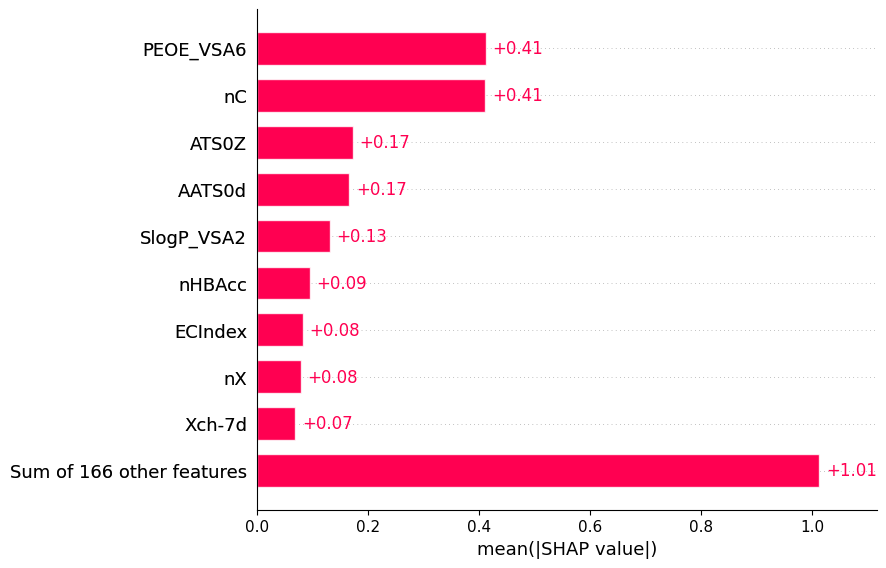

In [70]:
# better styling and compatibility

shap.plots.bar(shap_values, max_display=10,show=False)
plt.savefig('scratcch.pdf',bbox_inches='tight',dpi = 1000)

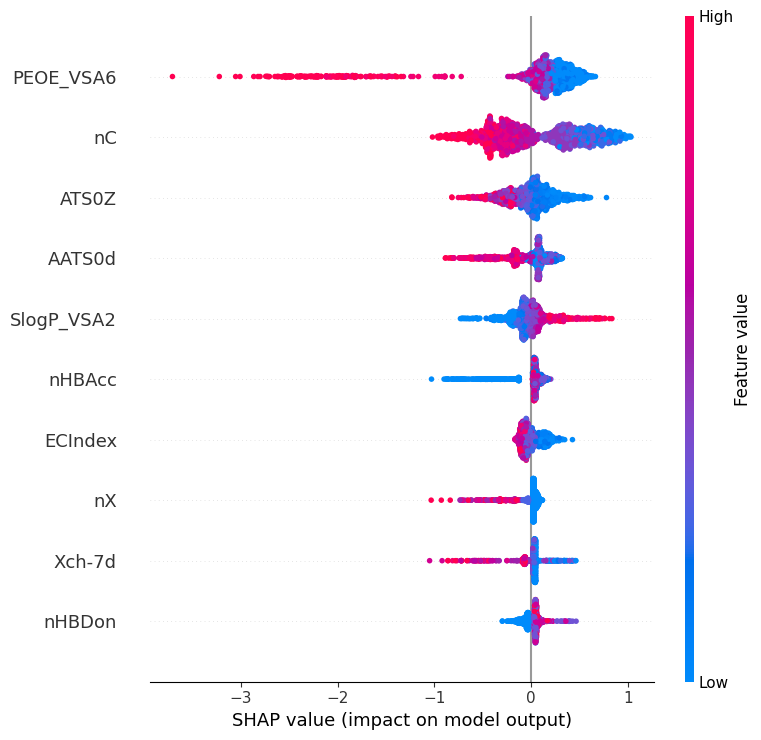

In [71]:
shap.summary_plot(shap_values, plot_type="dot", plot_size=0.6, show=False,max_display=10)
plt.savefig('scratcch.pdf',bbox_inches='tight',dpi = 1000)

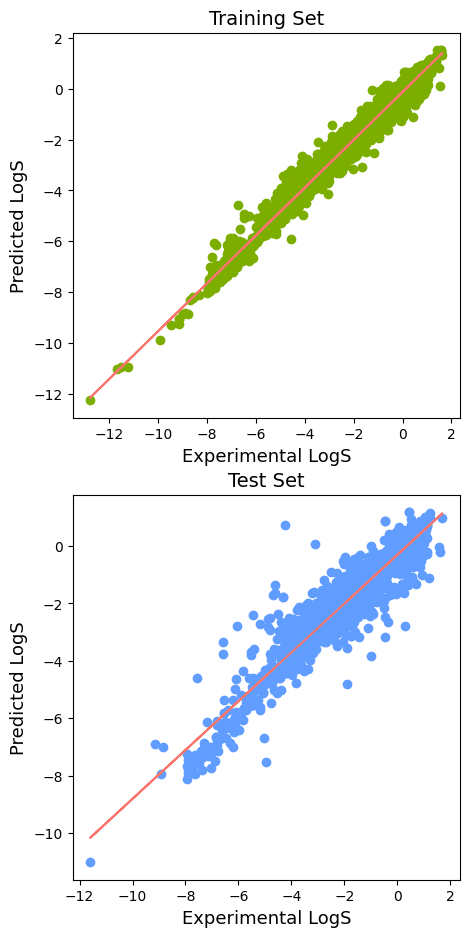

In [75]:
#Vertical plot
#comparison of predicted vs experimental LogS values for both training and test data
plt.figure(figsize=(5,11))

# 2 row, 1 column, plot 1
plt.subplot(2, 1, 1)
plt.scatter(x=Y_train, y=Y_pred_train, c="#7CAE00", alpha=1)


z = np.polyfit(Y_train, Y_pred_train, 1)
p = np.poly1d(z)
plt.plot(Y_train,p(Y_train),"#F8766D")


plt.xlabel('Experimental LogS', fontsize=13)
plt.ylabel('Predicted LogS', fontsize=13)
plt.title('Training Set', fontsize=14)


# 2 row, 1 column, plot 2
plt.subplot(2, 1, 2)
plt.scatter(x=Y_test, y=Y_pred_test, c="#619CFF", alpha=1)

z = np.polyfit(Y_test, Y_pred_test, 1)
p = np.poly1d(z)
plt.plot(Y_test,p(Y_test),"#F8766D")

plt.ylabel('Predicted LogS', fontsize=13)
plt.xlabel('Experimental LogS', fontsize=13)
plt.title('Test Set', fontsize=14)

plt.savefig('plot_vertical_logS.png')
plt.savefig('paper logS descriptor.pdf',dpi=1200)
plt.show()